In [1]:
# Imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons, CheckButtons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Circle, Wedge, Polygon
import math
import os
import time
import itertools

import joblib

import warnings
warnings.filterwarnings('ignore')

from matplotlib.patches import Circle, Wedge
from matplotlib.collections import PatchCollection

from sklearn.metrics import pairwise_distances

#plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'monospace'
#plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"

%matplotlib notebook

plt.rcParams['figure.figsize'] = [7, 7]

import torch
import torch.nn
import torch.utils.data
import torchvision

In [2]:
class SimpleNet(torch.nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = torch.nn.Linear(2, 3)
        self.fc4 = torch.nn.Linear(3, 2)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc4(x)
        
        return x

In [3]:
def calcRegion(network, data):
    network.zero_grad()
    output = network(data)
    output = output[:, 1] - output[:, 0]
    g = torch.autograd.grad(torch.sum(output), data)[0].data
    
    weights = np.array(g.tolist())
    
    inputs = np.array(data.tolist())
    result = np.sum(np.multiply(weights,inputs), axis=1)
    biases = np.array(output.tolist()) - result
    
    regions = np.concatenate((weights, biases[:, None]), axis=1)
    
    return regions

def getRegions(network, dataLoader):
    regions = np.array([]).reshape(0, 3)
    for batch_idx, (data, target) in enumerate(dataLoader):
        data.requires_grad_()
        region = calcRegion(network, data)
        regions = np.concatenate((regions, region), axis=0)
        
    return np.array(regions)

In [4]:
def calcZs(network, bounds=2, res=201):
    As = []
    bs = []
    params = list(network.parameters())
    for i in range(0, len(params), 2):
        As.append(params[i].data.numpy())
        bs.append(params[i+1].data.numpy())
    
    
    x = np.linspace(-bounds, bounds, res)
    y = np.copy(x)

    X, Y = np.meshgrid(x, y)
    origShape = X.shape

    X = np.reshape(X, -1)
    Y = np.reshape(Y, -1)

    inputVal = np.vstack((X, Y))

    dataset = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.Tensor(inputVal).T,torch.Tensor(inputVal).T), batch_size=10000)
    
    regions = getRegions(network, dataset)
    regions = np.unique(np.around(regions, decimals=2), axis=0)
    
    outs = []
    outs.append((np.matmul(As[0], inputVal).T + bs[0]).T)
    for i in range(1, len(As)):
        outs.append((np.matmul(As[i], np.maximum(outs[i-1], 0)).T + bs[i]).T)

    X = np.reshape(X, origShape)
    Y = np.reshape(Y, origShape)
    
    return X, Y, outs, regions

In [5]:
def plotNodeColored(X, Y, val, color, ax):
    Z = np.reshape(val, X.shape)
    ax.contour(X, Y, Z, [0], colors=color);
        
def plotLayerUncolored(X, Y, vals, alpha, ax):
    for i in range(vals.shape[0]):
        Z = np.reshape(vals[i, :], X.shape)
        ax.contour(X, Y, Z, [0], colors='k', alpha=alpha);
        
def plotLayersUncolored(X, Y, valList, ax):    
    alpha = 0.25
    
    for val in valList[::-1]:
        plotLayerUncolored(X, Y, val, alpha, ax)

In [6]:
def plotPolytopeRegions(X, Y, f, g, ax):
    origShape = X.shape

    X = np.reshape(X, -1)[:, None]
    Y = np.reshape(Y, -1)[:, None]

    inputVal = np.concatenate((X, Y), axis=1)

    fIndices = f.calcIndex(inputVal)
    gIndices = g.calcIndex(inputVal)

    combos = set()
    for i in range(fIndices.shape[0]):
        combos.add((fIndices[i], gIndices[i]))

    lRegions = []
    for elem in combos:
        lRegions.append(f.monomials[elem[0], :] - g.monomials[elem[1], :])
    lRegions = np.unique(lRegions, axis=0)
    
    ax.scatter(lRegions[:, 0], lRegions[:, 1], lRegions[:, 2])
    ax.set_title('Linear Regions\n{} regions'.format(lRegions.shape[0]))

In [7]:
accuracies = np.load('accuraciesCircle.npy')
indices = np.load('indicesCircle.npy')

Time taken to 999 is 4.595116376876831
Time taken to 998 is 9.44412088394165
Time taken to 997 is 13.853262901306152
Time taken to 996 is 18.556156158447266
Time taken to 995 is 23.212141036987305
Time taken to 994 is 27.60205578804016
Time taken to 993 is 31.990158796310425
Time taken to 992 is 36.80213713645935
Time taken to 991 is 41.67812490463257
Time taken to 990 is 46.68311858177185
Time taken to 989 is 51.313050985336304
Time taken to 988 is 56.32913899421692
Time taken to 987 is 61.03113913536072
Time taken to 986 is 66.65613961219788
Time taken to 985 is 72.19912886619568
Time taken to 984 is 76.71454429626465
Time taken to 983 is 81.9391360282898
Time taken to 982 is 87.08511137962341
Time taken to 981 is 92.25811052322388
Time taken to 980 is 97.18541860580444
Time taken to 979 is 103.11311626434326
Time taken to 978 is 108.12012076377869
Time taken to 977 is 113.27912592887878
Time taken to 976 is 118.81811857223511
Time taken to 975 is 123.82011365890503
Time taken to 974

Time taken to 790 is 1106.7681348323822
Time taken to 789 is 1112.0347702503204
Time taken to 788 is 1117.3091235160828
Time taken to 787 is 1122.656109571457
Time taken to 786 is 1127.9871068000793
Time taken to 785 is 1133.0641210079193
Time taken to 784 is 1138.2601153850555
Time taken to 783 is 1143.601102590561
Time taken to 782 is 1149.1155903339386
Time taken to 781 is 1154.5331373214722
Time taken to 780 is 1159.9970135688782
Time taken to 779 is 1165.4141054153442
Time taken to 778 is 1170.6001181602478
Time taken to 777 is 1175.898121356964
Time taken to 776 is 1181.1941168308258
Time taken to 775 is 1186.4671142101288
Time taken to 774 is 1192.096112728119
Time taken to 773 is 1197.3202033042908
Time taken to 772 is 1202.7971308231354
Time taken to 771 is 1208.1421315670013
Time taken to 770 is 1213.787118434906
Time taken to 769 is 1219.1531105041504
Time taken to 768 is 1224.609143257141
Time taken to 767 is 1229.8001201152802
Time taken to 766 is 1235.2901661396027
Time t

Time taken to 583 is 2220.3911242485046
Time taken to 582 is 2225.657125234604
Time taken to 581 is 2231.147121191025
Time taken to 580 is 2236.559148788452
Time taken to 579 is 2241.903659105301
Time taken to 578 is 2247.184110879898
Time taken to 577 is 2252.783150911331
Time taken to 576 is 2258.1691148281097
Time taken to 575 is 2263.497113466263
Time taken to 574 is 2268.54212975502
Time taken to 573 is 2273.9191076755524
Time taken to 572 is 2279.2521073818207
Time taken to 571 is 2284.4951996803284
Time taken to 570 is 2289.6651084423065
Time taken to 569 is 2295.0031478405
Time taken to 568 is 2300.5001258850098
Time taken to 567 is 2307.001118659973
Time taken to 566 is 2313.437115907669
Time taken to 565 is 2319.7251269817352
Time taken to 564 is 2326.8751196861267
Time taken to 563 is 2332.573891401291
Time taken to 562 is 2338.512127161026
Time taken to 561 is 2343.9651284217834
Time taken to 560 is 2349.142106294632
Time taken to 559 is 2354.7091152668
Time taken to 558 is

Time taken to 375 is 3341.9211184978485
Time taken to 374 is 3347.1351487636566
Time taken to 373 is 3352.3411135673523
Time taken to 372 is 3357.5571563243866
Time taken to 371 is 3363.0356047153473
Time taken to 370 is 3368.445128917694
Time taken to 369 is 3373.999115228653
Time taken to 368 is 3379.341155767441
Time taken to 367 is 3384.751765012741
Time taken to 366 is 3390.437115907669
Time taken to 365 is 3396.8540527820587
Time taken to 364 is 3402.618612766266
Time taken to 363 is 3407.843143224716
Time taken to 362 is 3413.121118783951
Time taken to 361 is 3418.5511326789856
Time taken to 360 is 3423.844110250473
Time taken to 359 is 3429.0024795532227
Time taken to 358 is 3434.638142347336
Time taken to 357 is 3439.8741252422333
Time taken to 356 is 3445.5311331748962
Time taken to 355 is 3450.843114376068
Time taken to 354 is 3455.980502843857
Time taken to 353 is 3461.1971123218536
Time taken to 352 is 3466.7145812511444
Time taken to 351 is 3472.0094017982483
Time taken t

Time taken to 166 is 4556.361821651459
Time taken to 165 is 4562.050115346909
Time taken to 164 is 4569.310107707977
Time taken to 163 is 4575.985127449036
Time taken to 162 is 4581.517117500305
Time taken to 161 is 4586.854117631912
Time taken to 160 is 4592.339119911194
Time taken to 159 is 4598.072320222855
Time taken to 158 is 4603.439118862152
Time taken to 157 is 4608.567122936249
Time taken to 156 is 4614.572130680084
Time taken to 155 is 4620.691113233566
Time taken to 154 is 4626.416130542755
Time taken to 153 is 4632.668109893799
Time taken to 152 is 4638.11816573143
Time taken to 151 is 4643.723135948181
Time taken to 150 is 4648.794116735458
Time taken to 149 is 4653.840105295181
Time taken to 148 is 4658.816116571426
Time taken to 147 is 4664.427114486694
Time taken to 146 is 4670.476123094559
Time taken to 145 is 4675.679103851318
Time taken to 144 is 4681.262343645096
Time taken to 143 is 4686.830142498016
Time taken to 142 is 4692.299559593201
Time taken to 141 is 4697.

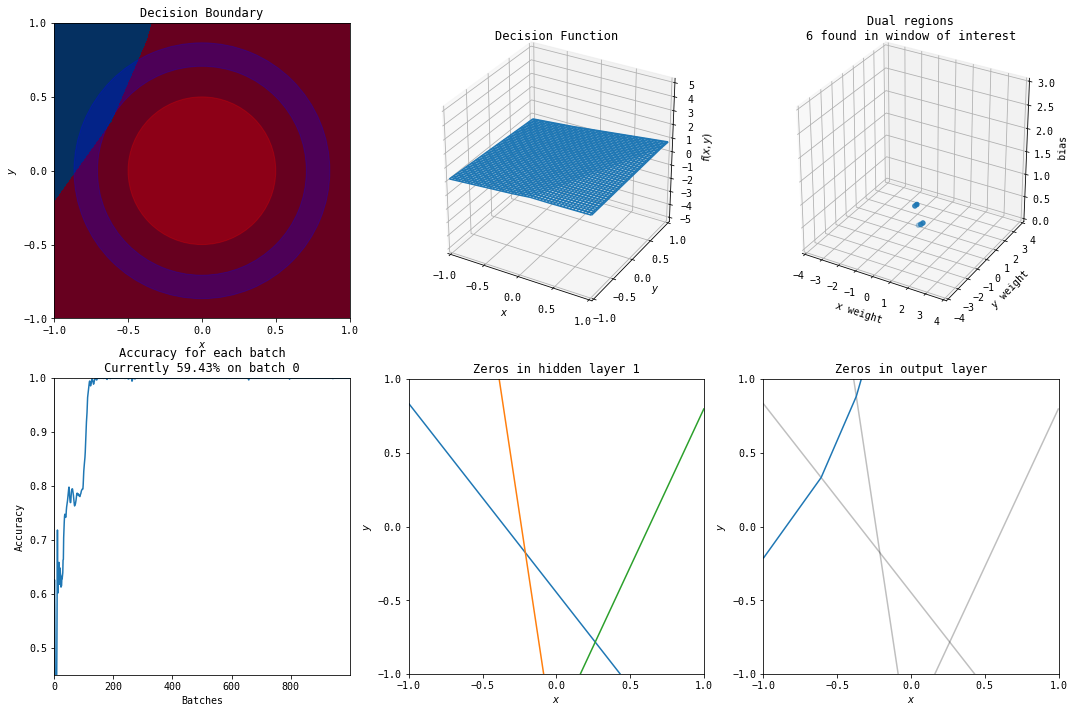

In [8]:
fig = plt.figure(figsize=(18, 12))

axDecision=fig.add_subplot(231)
axWireframe=fig.add_subplot(232, projection='3d')
axRegions=fig.add_subplot(233, projection='3d')
axAccuracies=fig.add_subplot(234)

axFirst = fig.add_subplot(235)
axFourth = fig.add_subplot(236)

axPolytopes = [axFirst, axFourth]

# Get rid of gray
colors = list(matplotlib.colors.TABLEAU_COLORS.keys())

r1 = 0.5
r2 = np.sqrt(2*r1**2)
r3 = np.sqrt(3*r1**2)

start = time.time()
for i in indices[::-1]:
    
    network = torch.load('trainedNetsCircle/network{:09d}.pt'.format(i))
    X, Y, outs, regions = calcZs(network, bounds=1, res=401)

    for ax in [axDecision, axFirst, axFourth]:
        ax.clear()
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        ax.set_xticks(np.arange(-1, 1.5, 0.5))
        ax.set_yticks(np.arange(-1, 1.5, 0.5))
        ax.set_aspect('equal')
        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')
        
    axWireframe.clear()
    axWireframe.set_xlim([-1, 1])
    axWireframe.set_ylim([-1, 1])
    axWireframe.set_xticks(np.arange(-1, 1.5, 0.5))
    axWireframe.set_yticks(np.arange(-1, 1.5, 0.5))
    #axWireframe.set_zticks([])
    axWireframe.set_title('Decision Function')
    axWireframe.set_xlabel('$x$')
    axWireframe.set_ylabel('$y$')
    axWireframe.set_zlabel('$f(x, y)$')
    axWireframe.set_zlim([-5.1, 5.1])
    axWireframe.set_zticks(range(-5, 6))
    
    axRegions.clear()
    axRegions.scatter(regions[:, 0], regions[:, 1], regions[:, 2])
    axRegions.set_title('Dual regions\n{} found in window of interest'.format(regions.shape[0]))
    axRegions.set_xlabel('$x$ weight')
    axRegions.set_ylabel('$y$ weight')
    axRegions.zaxis.set_rotate_label(True)
    axRegions.set_zlabel('bias')
    
    axRegions.set_xlim([-4, 4])
    axRegions.set_ylim([-4, 4])
    axRegions.set_zlim([0, 3])
    
    
    # Accuracy
    axAccuracies.clear()
    axAccuracies.plot(accuracies)
    axAccuracies.set_xlabel('Batches')
    axAccuracies.set_ylabel('Accuracy')
    axAccuracies.set_ylim([0.45, 1.0])
    axAccuracies.set_xlim([0, indices[-1]])
    axAccuracies.plot([i, i], [0, 100], 'k', alpha=0.5)
    axAccuracies.set_title('Accuracy for each batch\nCurrently {:.2f}% on batch {}'.format(100*accuracies[i], i))
    
    output = outs[-1][1] - outs[-1][0]
    output = output.reshape(X.shape)

    # Raw outputs
    axDecision.contourf(X, Y, output, vmin=-0.001, vmax=0.001,cmap='RdBu_r')
    axDecision.set_title('Decision Boundary')
    
    circle = Circle((0, 0), 0.5, color='r', alpha=0.25)
    annulus = Wedge((0, 0), r3, 0, 360, width=r3-r2, color='b', alpha=0.25)
    axDecision.add_artist(circle)
    axDecision.add_artist(annulus)
    
    # Wireframe
    axWireframe.plot_wireframe(X, Y, output)
    
    # Polytope construction
    for k in range(1):
        if k > 0:
            plotLayersUncolored(X, Y, outs[:k], axPolytopes[k])
        for j in range(len(outs[k])):
            plotNodeColored(X, Y, outs[k][j], colors[j], axPolytopes[k])
        axPolytopes[k].set_title('Zeros in hidden layer {}'.format(k+1))
        
    plotLayersUncolored(X, Y, outs[:-1], axPolytopes[-1])
    plotNodeColored(X, Y, output, colors[0], axPolytopes[-1])
    axPolytopes[-1].set_title('Zeros in output layer')

    fig.show()
    fig.canvas.draw()

    fig.savefig('circleTraining/{:09d}.png'.format(i), bbox_inches='tight')

    time.sleep(1)
    
    print('Time taken to {} is {}'.format(i, time.time()-start))

In [9]:
os.system('ffmpeg -r 5 -i circleTraining/%09d.png -r 10 circleTraining.mp4')

0